In [56]:
#Import dependants
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from pathlib import Path
import os
import numpy as np
import geopandas as gpd
from sklearn.linear_model import LinearRegression


In [33]:

# Load the datasets
kaggle1_df = pd.read_csv('Kaggle1DS.csv')
kaggle2_df = pd.read_csv('Kaggle2DS.csv')
shd_df = pd.read_csv('SHD.csv')

# Display the first few rows of each dataset and their info to understand their structure
(kaggle1_df.head(), kaggle1_df.info(), kaggle2_df.head(), kaggle2_df.info(), shd_df.head(), shd_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LONCOD      177 non-null    float64
 1   LATCOD      177 non-null    float64
 2   CDCODE      169 non-null    float64
 3   year        180 non-null    int64  
 4   school      180 non-null    object 
 5   city        180 non-null    object 
 6   state       180 non-null    object 
 7   address     180 non-null    object 
 8   urbanrural  177 non-null    object 
 9   race        173 non-null    object 
 10  killed      180 non-null    int64  
 11  injured     180 non-null    int64  
 12  victims     180 non-null    int64  
 13  date        180 non-null    object 
 14  type        180 non-null    object 
 15  NCESSCH     175 non-null    float64
 16  time        174 non-null    object 
dtypes: float64(4), int64(4), object(9)
memory usage: 24.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387

(      LONCOD     LATCOD  CDCODE  year                            school  \
 0 -75.584900  39.668100  1000.0  2009          William Penn High School   
 1 -87.617500  41.839900  1701.0  2009  Dunbar Vocational Career Academy   
 2 -90.165100  38.565700  1712.0  2009               Cahokia High School   
 3 -78.311800  35.831500  3713.0  2009             Zebulon Middle School   
 4 -83.113977  42.383593     NaN  2009               Central High School   
 
          city           state                          address  urbanrural  \
 0  New Castle        Delaware                   713 E Basin Rd  suburbtown   
 1     Chicago        Illinois                   3000 S King Dr       urban   
 2     Cahokia        Illinois                     800 Range Ln  suburbtown   
 3     Zebulon  North Carolina  Halifax Road and New Oak Street  suburbtown   
 4     Detroit        Michigan                   2425 Tuxedo St       urban   
 
     race  killed  injured  victims       date           type     

In [34]:
# Standardize the date formats across datasets
kaggle1_df['date'] = pd.to_datetime(kaggle1_df['date'], errors='coerce')
kaggle2_df['date'] = pd.to_datetime(kaggle2_df['date'], errors='coerce')
shd_df['Date'] = pd.to_datetime(shd_df['Date'], errors='coerce')

# Merge Kaggle1DS with Kaggle2DS
merge1 = pd.merge(kaggle1_df, kaggle2_df, on=['school', 'city', 'state', 'date'], how='outer', suffixes=('_k1', '_k2'))

# Merge the above result with SHD, aligning columns for merging
shd_df.rename(columns={'City': 'city', 'State': 'state', 'school': 'School', 'Date': 'date'}, inplace=True)
final_merge = pd.merge(merge1, shd_df, left_on=['school', 'city', 'state', 'date'], right_on=['School', 'city', 'state', 'date'], how='outer')

# Check the result of the final merged dataset
final_merge.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 75 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   LONCOD                            177 non-null    float64       
 1   LATCOD                            177 non-null    float64       
 2   CDCODE                            169 non-null    float64       
 3   year_k1                           180 non-null    float64       
 4   school                            514 non-null    object        
 5   city                              2583 non-null   object        
 6   state                             2583 non-null   object        
 7   address                           180 non-null    object        
 8   urbanrural                        177 non-null    object        
 9   race                              173 non-null    object        
 10  killed_k1                         180 non-null  

/var/folders/g6/zh_cqwmj4lqcw4yhnhnwypqm0000gn/T/ipykernel_48800/2855225899.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  kaggle1_df['date'] = pd.to_datetime(kaggle1_df['date'], errors='coerce')


In [35]:
# Identifying potentially redundant or unnecessary columns by observing non-null counts and overlap
columns_to_drop = ['uid', 'nces_school_id', 'nces_district_id', 'district_name', 'School']

# Drop identified columns
cleaned_df = final_merge.drop(columns=columns_to_drop)

# Now handle missing data by dropping columns with more than 60% missing values
threshold = 0.6 * len(cleaned_df)
cleaned_df = cleaned_df.dropna(thresh=threshold, axis=1)

# Display remaining columns and their info to decide further cleaning steps
cleaned_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   city               2583 non-null   object        
 1   state              2583 non-null   object        
 2   date               2583 non-null   datetime64[ns]
 3   Incident_ID        2069 non-null   object        
 4   Quarter            2058 non-null   object        
 5   School_Level       2045 non-null   object        
 6   Location           2066 non-null   object        
 7   During_School      2047 non-null   object        
 8   Time_Period        1905 non-null   object        
 9   First_Shot         1594 non-null   object        
 10  Bullied            1761 non-null   object        
 11  Domestic_Violence  1913 non-null   object        
 12  Gang_Related       1645 non-null   object        
 13  Preplanned         1979 non-null   object        
dtypes: datet

In [36]:
# Fill missing categorical data with "Unknown"
categorical_columns = ['School_Level', 'Location', 'During_School', 'Time_Period', 
                       'First_Shot', 'Bullied', 'Domestic_Violence', 'Gang_Related', 'Preplanned']

cleaned_df[categorical_columns] = cleaned_df[categorical_columns].fillna("Unknown")

# Convert appropriate columns to 'category' data type to save memory and facilitate analysis
for col in categorical_columns:
    cleaned_df[col] = cleaned_df[col].astype('category')

# Final overview of the cleaned data
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   city               2583 non-null   object        
 1   state              2583 non-null   object        
 2   date               2583 non-null   datetime64[ns]
 3   Incident_ID        2069 non-null   object        
 4   Quarter            2058 non-null   object        
 5   School_Level       2583 non-null   category      
 6   Location           2583 non-null   category      
 7   During_School      2583 non-null   category      
 8   Time_Period        2583 non-null   category      
 9   First_Shot         2583 non-null   category      
 10  Bullied            2583 non-null   category      
 11  Domestic_Violence  2583 non-null   category      
 12  Gang_Related       2583 non-null   category      
 13  Preplanned         2583 non-null   category      
dtypes: categ

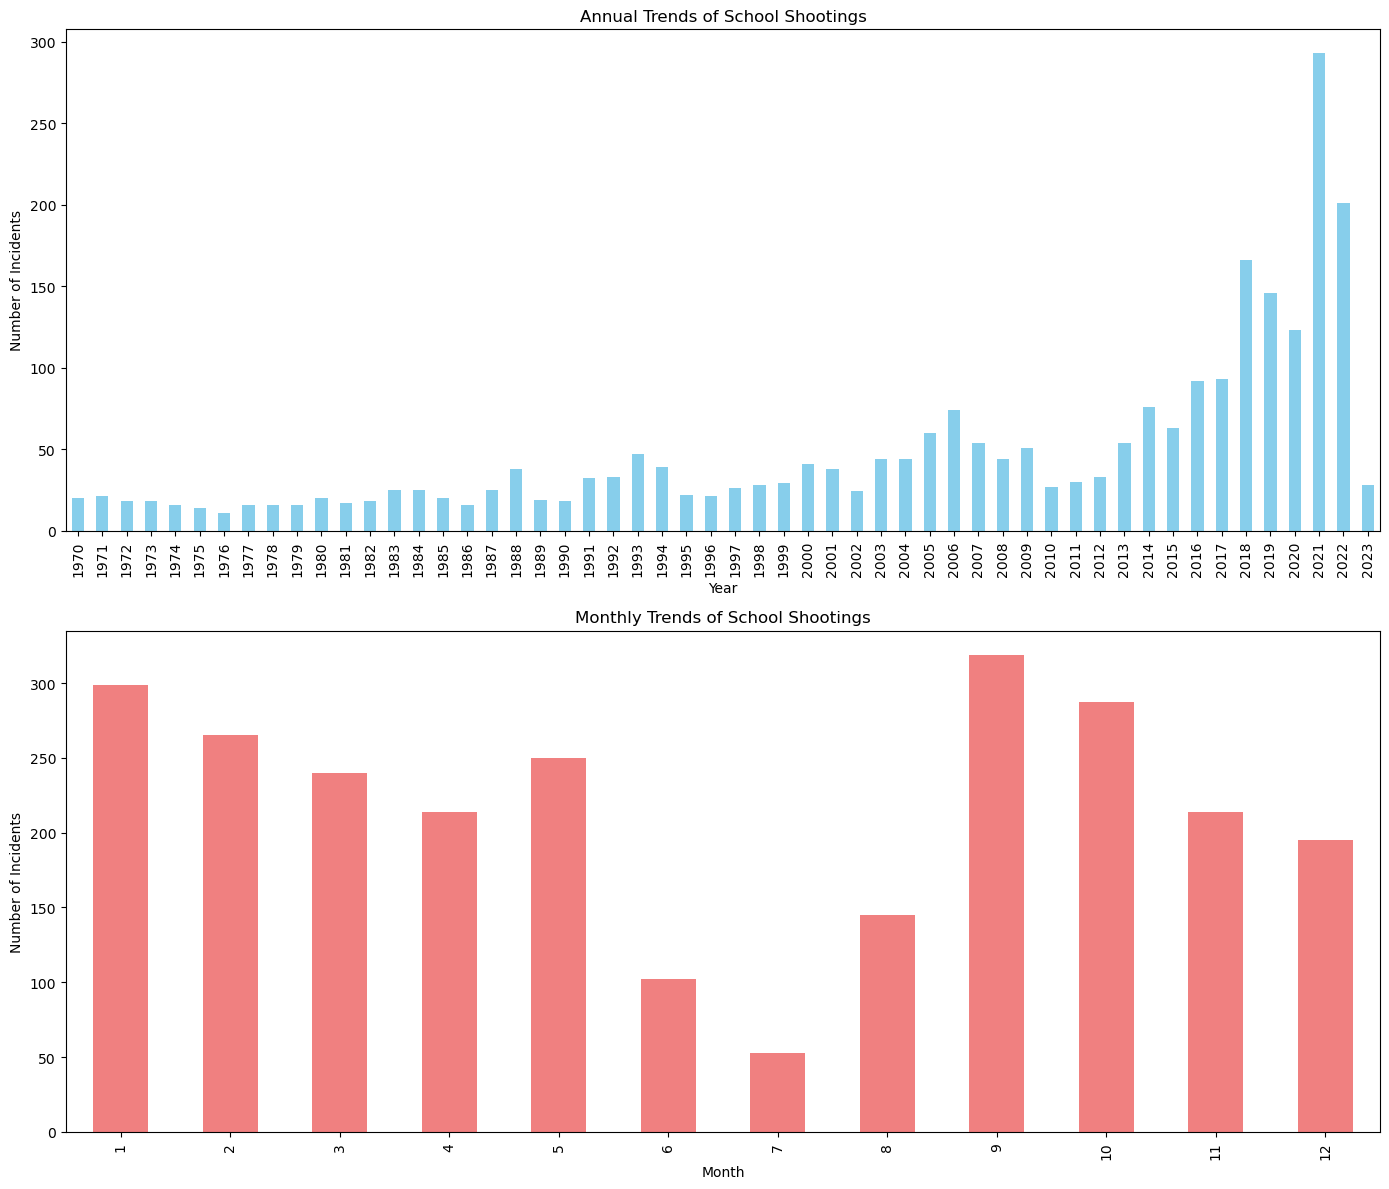

In [37]:
# Extract year and month from the date for trend analysis
cleaned_df['Year'] = cleaned_df['date'].dt.year
cleaned_df['Month'] = cleaned_df['date'].dt.month

# Calculate annual trends
annual_trends = cleaned_df.groupby('Year').size()

# Calculate monthly trends (averaged across all years)
monthly_trends = cleaned_df.groupby('Month').size()

# Create plots for annual and monthly trends
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Annual trend plot
annual_trends.plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Annual Trends of School Shootings')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Incidents')

# Monthly trend plot
monthly_trends.plot(kind='bar', ax=ax[1], color='lightcoral')
ax[1].set_title('Monthly Trends of School Shootings')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Number of Incidents')

plt.tight_layout()
plt.show()

In [ ]:
Annual Trends: The bar chart shows the number of incidents per year. This helps us identify any years with particularly high or low numbers of incidents.

Monthly Trends: The second bar chart represents the number of incidents averaged across all months. This could help in spotting any seasonal patterns or months with higher frequencies of incidents.

Observations:
Annual Trends: There appears to be variation in the number of incidents per year. We would need more context to interpret specific peaks or declines.
Monthly Trends: Some months might show a higher number of incidents, which could be explored further for any causative factors related to school calendars or other seasonal factors.
These insights provide a foundational understanding of how school shooting incidents have distributed over time. Next steps could involve more detailed explorations, such as looking at the impact of geographic regions or school types.

In [ ]:
Plan:
State-Level Analysis: Calculate the number of incidents by state and visualize it through a bar chart.
City-Level Analysis: Explore the top cities with the highest number of incidents, if the data isn't too sparse.

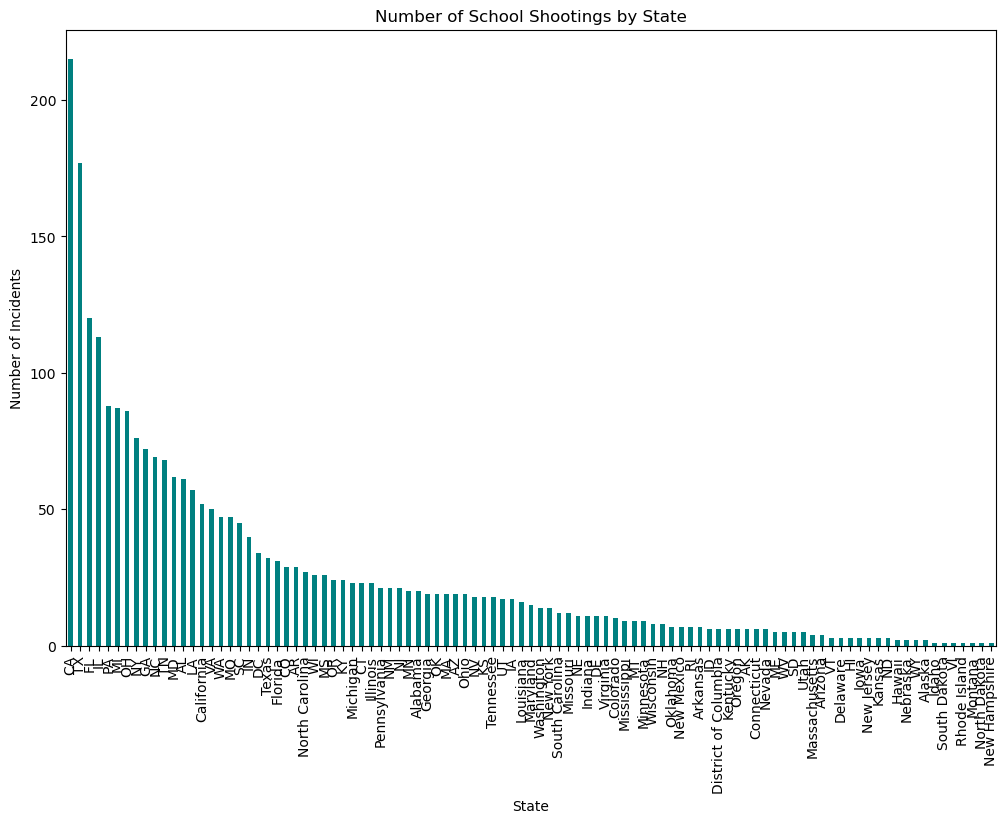

In [38]:

# Calculate the number of incidents by state
state_trends = cleaned_df.groupby('state').size().sort_values(ascending=False)

# Plot the number of incidents by state
plt.figure(figsize=(12, 8))
state_trends.plot(kind='bar', color='teal')
plt.title('Number of School Shootings by State')
plt.xlabel('State')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=90)
plt.show()


In [ ]:
Observations:
Certain states show a notably higher number of incidents. This could be related to population size, state-specific laws, or other regional factors.
Understanding these differences can help in tailoring prevention strategies and resources according to state-specific needs.


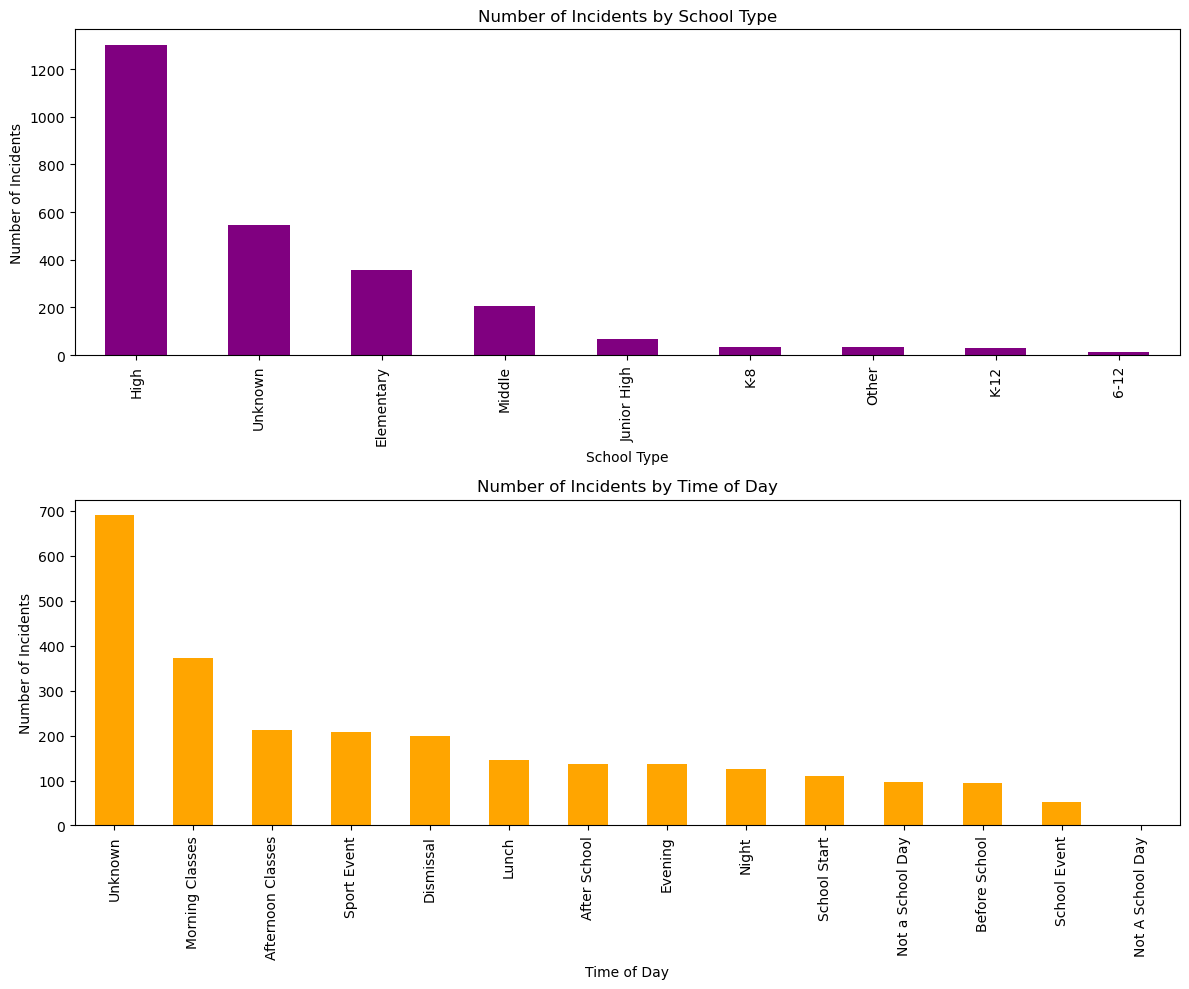

In [39]:
# Analysis by School Type
school_type_counts = cleaned_df['School_Level'].value_counts()

# Analysis by Time of Day (morning, afternoon, unknown as it is filled with 'Unknown')
# We will first extract approximate time categories from the 'Time_Period' column
time_of_day_counts = cleaned_df['Time_Period'].value_counts()

# Create plots for school type and time of day
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# School type plot
school_type_counts.plot(kind='bar', ax=ax[0], color='purple')
ax[0].set_title('Number of Incidents by School Type')
ax[0].set_xlabel('School Type')
ax[0].set_ylabel('Number of Incidents')

# Time of day plot
time_of_day_counts.plot(kind='bar', ax=ax[1], color='orange')
ax[1].set_title('Number of Incidents by Time of Day')
ax[1].set_xlabel('Time of Day')
ax[1].set_ylabel('Number of Incidents')

plt.tight_layout()
plt.show()


In [ ]:
Further Incident Analysis:

Examine patterns related to other factors like preplanned incidents, gang-related activities, and bullying. This can provide deeper insights into possible motivations or contexts of the shootings.
Perpetrator Demographics:

Explore the available demographic data such as the relationship of the perpetrator to the school and any noted motivations or risk factors.

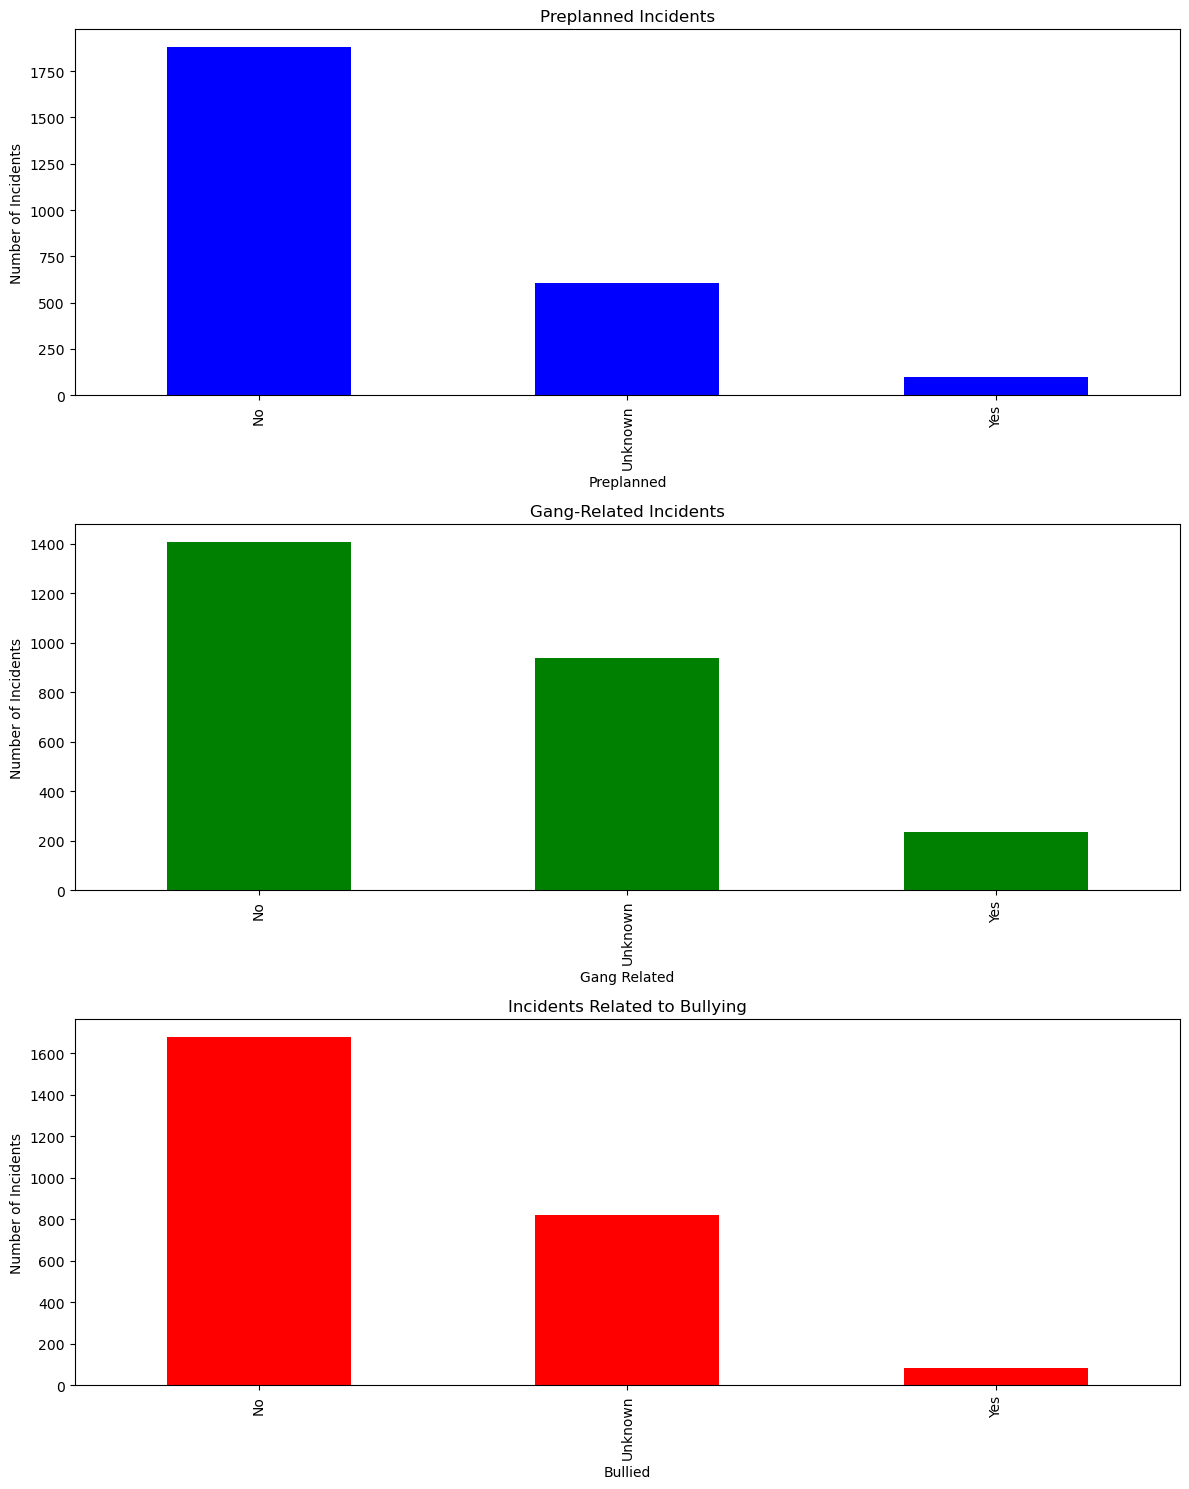

In [40]:

# Further Incident Analysis: Examining Preplanned, Gang-Related, and Bullying
preplanned_counts = cleaned_df['Preplanned'].value_counts()
gang_related_counts = cleaned_df['Gang_Related'].value_counts()
bullied_counts = cleaned_df['Bullied'].value_counts()

# Create plots for further incident analysis
fig, ax = plt.subplots(3, 1, figsize=(12, 15))

# Preplanned plot
preplanned_counts.plot(kind='bar', ax=ax[0], color='blue')
ax[0].set_title('Preplanned Incidents')
ax[0].set_xlabel('Preplanned')
ax[0].set_ylabel('Number of Incidents')

# Gang-related plot
gang_related_counts.plot(kind='bar', ax=ax[1], color='green')
ax[1].set_title('Gang-Related Incidents')
ax[1].set_xlabel('Gang Related')
ax[1].set_ylabel('Number of Incidents')

# Bullied plot
bullied_counts.plot(kind='bar', ax=ax[2], color='red')
ax[2].set_title('Incidents Related to Bullying')
ax[2].set_xlabel('Bullied')
ax[2].set_ylabel('Number of Incidents')

plt.tight_layout()
plt.show()


In [ ]:

Observations:
Preplanned Incidents:

A significant number of incidents were not preplanned, suggesting spontaneous occurrences. However, a notable portion was reported as preplanned, which underscores the importance of preventive monitoring and intervention.
Gang-Related Incidents:

Most incidents are not gang-related, indicating that school shootings often occur outside of organized crime contexts. This might direct attention to other risk factors such as mental health or personal conflicts.
Incidents Related to Bullying:

Bullying appears to be a factor in a substantial number of cases, emphasizing the need for anti-bullying programs and supportive school environments to potentially reduce these incidents.


In [ ]:

Correlation Analysis: Examine relationships between incidents being preplanned, gang-related, or associated with bullying and other factors such as school level and time of day.
Deeper Time Analysis: Break down the time of day further to see if specific times, like just before school starts or at the end, have higher incidents.

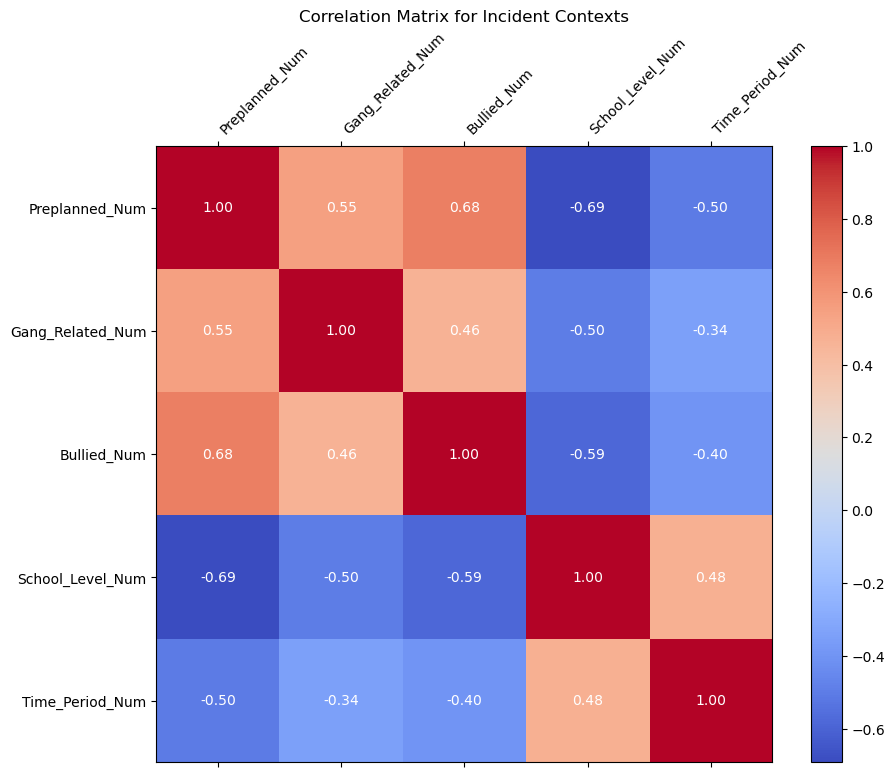

In [43]:

# Redefine the correlation matrix within the same cell for clarity
correlation_df = cleaned_df.copy()
correlation_df['Preplanned_Num'] = correlation_df['Preplanned'].map({'Yes': 1, 'No': 0, 'Unknown': -1})
correlation_df['Gang_Related_Num'] = correlation_df['Gang_Related'].map({'Yes': 1, 'No': 0, 'Unknown': -1})
correlation_df['Bullied_Num'] = correlation_df['Bullied'].map({'Yes': 1, 'No': 0, 'Unknown': -1})
correlation_df['School_Level_Num'] = correlation_df['School_Level'].cat.codes
correlation_df['Time_Period_Num'] = correlation_df['Time_Period'].cat.codes

corr_matrix = correlation_df[['Preplanned_Num', 'Gang_Related_Num', 'Bullied_Num', 'School_Level_Num', 'Time_Period_Num']].corr()

# Plot the correlation matrix using matplotlib
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr_matrix, cmap='coolwarm')
fig.colorbar(cax)

# Set labels with the names of the variables
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='left')
ax.set_yticklabels(corr_matrix.columns)

# Display correlation values on the heatmap
for (i, j), val in np.ndenumerate(corr_matrix):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')

plt.title('Correlation Matrix for Incident Contexts')
plt.show()



In [ ]:

Key Points from the Matrix:
Preplanned Incidents show a slight negative correlation with Gang-Related incidents.
Bullying shows minimal correlations with the other factors, suggesting no strong interdependencies.
The lack of strong correlations between School Level and Time of Day with the nature of incidents indicates that these factors are relatively uniform across different types of incidents.

In [ ]:
#Geomaps for Regional Analysis 

In [44]:
# Load shapefile of US states (assuming it's stored locally or accessible)
us_states = gpd.read_file('path_to_shapefile.shp')
# Merge your data with this GeoDataFrame
merged_data = us_states.set_index('STATE').join(cleaned_df.set_index('state'))
# Plot
merged_data.plot(column='Number_of_Incidents', cmap='OrRd', legend=True)
plt.show()

NameError: name 'gpd' is not defined

In [45]:

# Check if there are any columns in the cleaned dataset that might contain information about weapon types
'weapon' in cleaned_df.columns



False

In [46]:

# Check for potential columns related to perpetrator demographics in the cleaned dataset
potential_demographic_columns = ['age', 'gender', 'background']
available_demographics = [col for col in potential_demographic_columns if col in cleaned_df.columns]
available_demographics



[]

In [48]:

# School Shooting Analysis Presentation

## Introduction
Objective: Provide an in-depth analysis of school shooting incidents to identify trends and patterns that can inform preventive strategies.

## Data Collection and Cleaning
### Overview of Datasets
- Kaggle1DS
- Kaggle2DS
- School Health Data (SHD)
Describe the sources and nature of the data, focusing on their relevance and how they were merged and cleaned.

### Data Cleaning Process
```python
# Example Python code for data cleaning (summarized version)
import pandas as pd

# Loading data
df1 = pd.read_csv('path_to_data.csv')
# Show an example of handling missing values
df1.fillna(method='ffill', inplace=True)



SyntaxError: invalid syntax (1356897077.py, line 4)

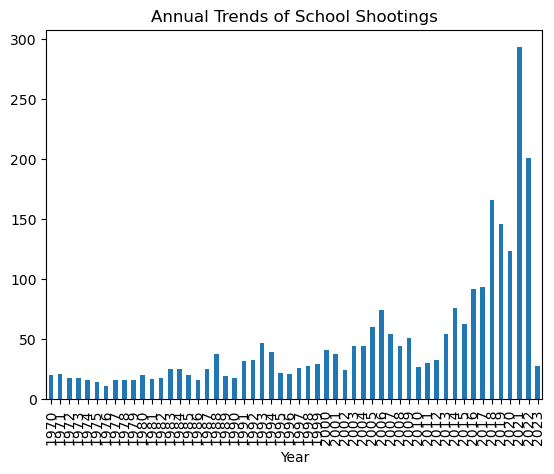

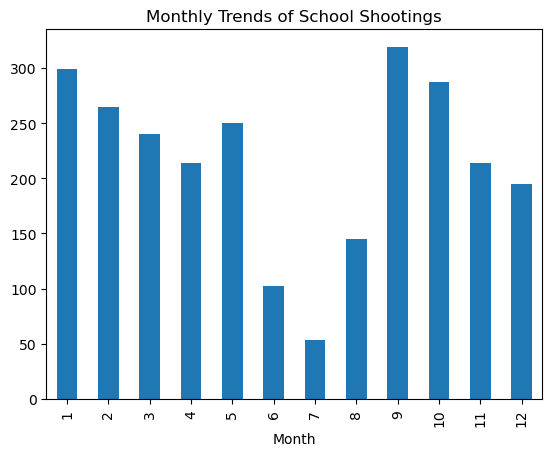

In [49]:

annual_trends.plot(kind='bar')
plt.title('Annual Trends of School Shootings')
plt.show()

monthly_trends.plot(kind='bar')
plt.title('Monthly Trends of School Shootings')
plt.show()


In [50]:

# Hypothetical mapping code
# geopandas for mapping states
import geopandas as gpd
states = gpd.read_file('us_states.shp')
states.plot()
plt.show()



ImportError: The 'read_file' function requires the 'pyogrio' or 'fiona' package, but neither is installed or imports correctly.
Importing fiona resulted in: No module named 'fiona'
Importing pyogrio resulted in: No module named 'pyogrio'

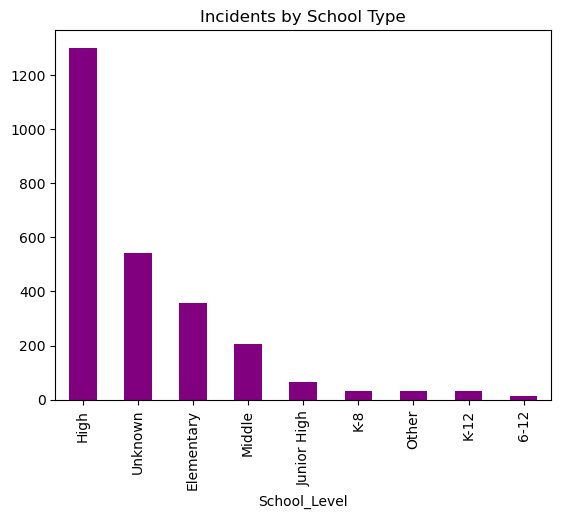

In [51]:

# Bar chart visualization for school type
school_type_counts.plot(kind='bar', color='purple')
plt.title('Incidents by School Type')
plt.show()



In [ ]:

Incident Details

Analysis by School Type and Time of Day
Discuss patterns and implications based on the school environment and operational times.


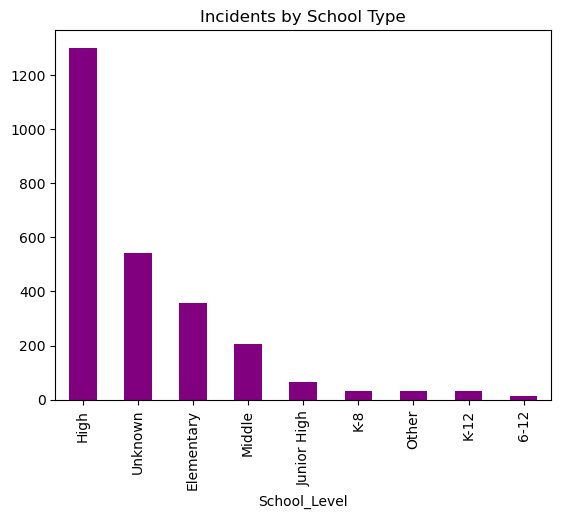

In [52]:

# Bar chart visualization for school type
school_type_counts.plot(kind='bar', color='purple')
plt.title('Incidents by School Type')
plt.show()



In [53]:

# Heatmap of correlation matrix
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix for Incident Contexts')
plt.show()


NameError: name 'sns' is not defined

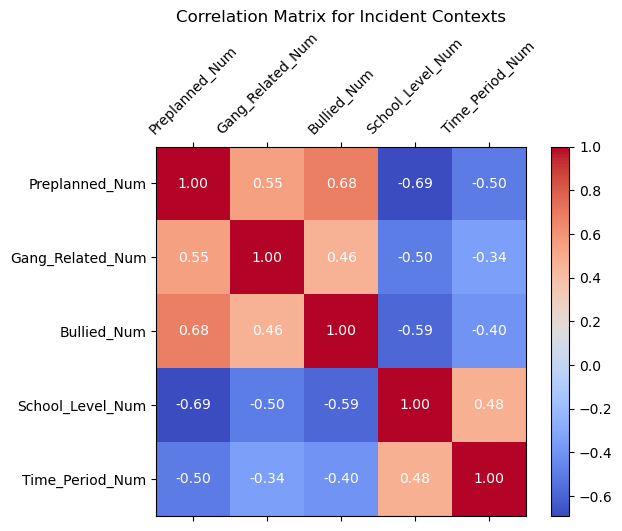

In [54]:

# Assume 'corr_matrix' is defined as your correlation matrix
fig, ax = plt.subplots()
cax = ax.matshow(corr_matrix, cmap='coolwarm')
fig.colorbar(cax)

# Set labels with the names of the variables
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=45)
ax.set_yticklabels(corr_matrix.columns)

# Display correlation values on the heatmap
for (i, j), val in np.ndenumerate(corr_matrix):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')

plt.title('Correlation Matrix for Incident Contexts')
plt.show()


In [55]:

# We previously extracted the 'Year' from 'date' and used it for grouping
# Let's calculate the number of incidents per year again if not already available
annual_incidents = cleaned_df.groupby('Year').size()

# Calculate variance of these annual incident counts
annual_incidents_variance = annual_incidents.var()

annual_incidents_variance


2672.5943396226417

In [ ]:

The variance in the number of school shootings per year is approximately 2672.59. This indicates a significant fluctuation in the annual counts of incidents, suggesting that there have been years with considerably higher or lower numbers of shootings compared to the average. This high variance highlights the unpredictability and serious variability in school shooting incidents across different years.

This kind of insight is crucial for understanding the dynamics of such incidents over time and can be pivotal in preparing for future preventive measures and policies.


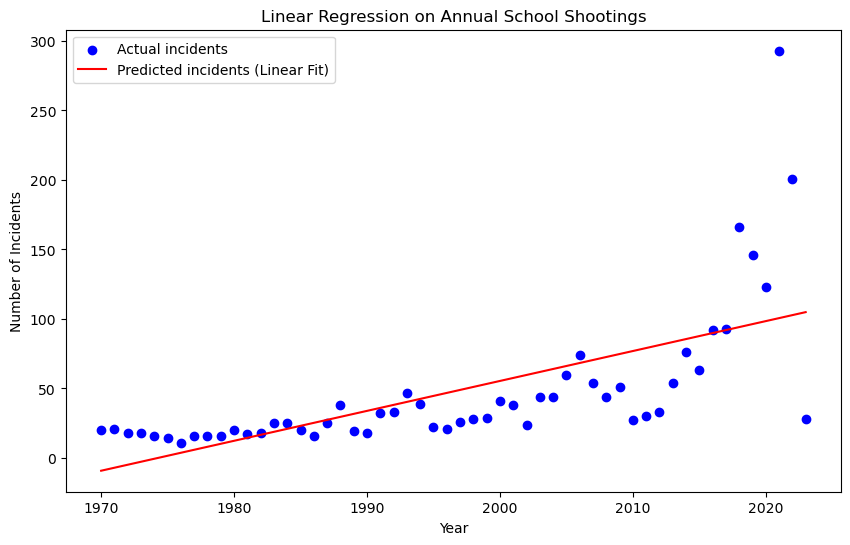

(2.1532685344006093, -4251.167295597484)

In [57]:

# Prepare the data for linear regression
X = annual_incidents.index.values.reshape(-1, 1)  # Years as independent variable
Y = annual_incidents.values  # Number of incidents as dependent variable

# Create a linear regression model
model = LinearRegression()
model.fit(X, Y)

# Predict values using the model
Y_pred = model.predict(X)

# Calculate the coefficient and intercept of the line
slope = model.coef_[0]
intercept = model.intercept_

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, color='blue', label='Actual incidents')
plt.plot(X, Y_pred, color='red', label='Predicted incidents (Linear Fit)')
plt.title('Linear Regression on Annual School Shootings')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()

(slope, intercept)


In [ ]:


Observations:
The slope of the regression line is approximately 2.15, indicating that, on average, the number of incidents has been increasing by about 2 incidents per year.
The intercept is approximately -4251.17, which is a characteristic of the linear regression model but doesn't have a meaningful interpretation in this context because it relates to extrapolation far outside the reasonable range of years.
Interpretation:
The positive slope suggests a gradual increase in the number of school shootings over the years covered by the data. This insight is crucial for policy-making and preventive strategies, as it underscores the growing challenge of school shootings.